# Performance evaluation

On the simulation environment, agents were benchmarked against BOBYQA. First, evaluations were conducted on a fully-observable evaluation environment, then on a partially-observable evaluation environment (hidden delays actived).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import os
import sys

# Get the current directory of the notebook
current_dir = os.path.dirname(os.path.abspath('__file__'))
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from mkp_delays_rl.helper_functions.performance_evaluation import *
from mkp_delays_rl.mkpdelays_env import MKPOptEnv

# update some global settings for plots
plt.rcParams.update({
    'font.family': 'sans-serif',  
    'font.size': 11, 
    'font.weight': 'heavy',
    'axes.labelweight': 'heavy',
    'axes.titleweight': 'heavy',
})

## BOBYQA

First, the current tool, BOBYQA, was evaluated as a benchmark.

In [ ]:
# BOBYQA
metrics = performance_evaluation_bobyqa(
        dtc=200,
        action_scaling=0.015,
        max_rise_time_change=0.02,
        max_steps=1000,
        hidden_delays=True,
        num_episodes=100,
        seed=10815)

with open("data/BOBYQA_metrics.pickle", "wb") as f:
        pickle.dump(metrics, f, protocol=pickle.HIGHEST_PROTOCOL)

## PPO trained on fully-observable environment

PPO, which was trained on the fully-observable environment during the step size study, was evaluated on a fully-observable and a partially observable environment. 

In [ ]:
# Evaluation on fully-observable env
model = PPO.load('agents/step_size_study/PPO_15ns.zip')

episode_data = performance_evaluation_non_recurrent(
    model=model,
    dtc=200,
    action_scaling=0.015,
    max_rise_time_change=0.02,
    max_steps=1000,
    hidden_delays=False,
    num_episodes=10000,
    seed=10815)

median_loss = []

# convert to loss
for ele in episode_data['all_rewards']:
    final_reward = np.median(ele)
    loss = (final_reward + 1) * (-1e-4 - (-1e-3)) / 2 + (-1e-3)
    median_loss.append(loss)

with open("data/PPO_fully_observable_loss.pickle", "wb",) as f:
    pickle.dump(median_loss, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Evaluation on partially-observable env
model = PPO.load('agents/step_size_study/PPO_15ns.zip')

episode_data = performance_evaluation_non_recurrent(
    model=model,
    dtc=200,
    action_scaling=0.015,
    max_rise_time_change=0.02,
    max_steps=1000,
    hidden_delays=True,
    num_episodes=10000,
    seed=10815)

median_loss = []

# convert to loss
for ele in episode_data['all_rewards']:
    final_reward = np.median(ele)
    loss = (final_reward + 1) * (-1e-4 - (-1e-3)) / 2 + (-1e-3)
    median_loss.append(loss)

with open("data/PPO_partially_observable_loss.pickle", "wb",) as f:
    pickle.dump(median_loss, f, protocol=pickle.HIGHEST_PROTOCOL)

The performance of PPO on the fully-observable and on the partially-observable environment is compared with BOBYQA and displayed as boxplots.

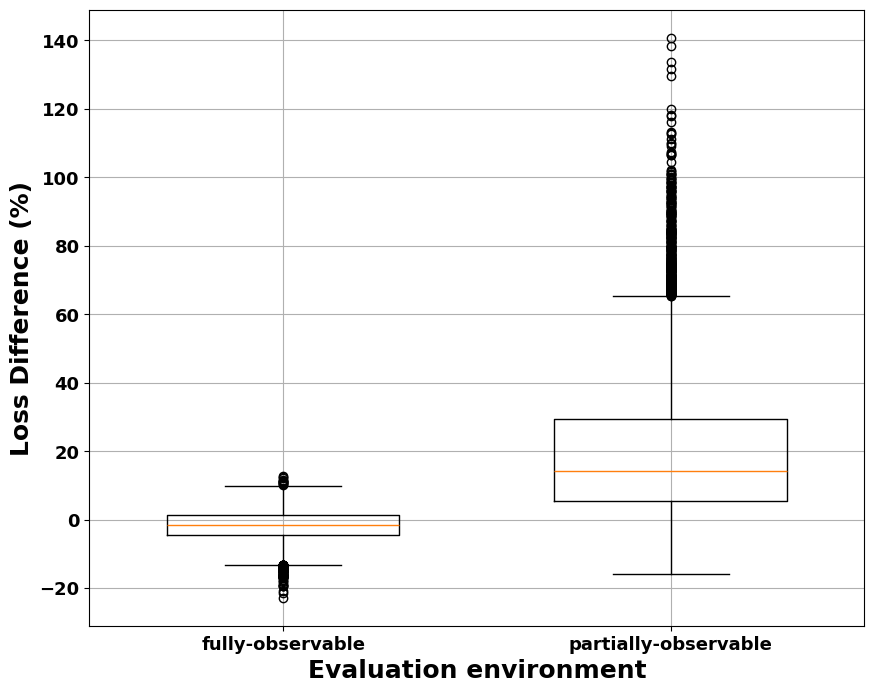

In [6]:
# BOBYQA results
with open('data/BOBYQA_metrics.pickle', 'rb') as f:
    bobyqa_metrics = pickle.load(f)
    
bobyqa_loss = []

for ele in bobyqa_metrics['final_x']:
    loss = -1 * (np.abs(ele[0]) ** 2 + np.abs(ele[1]) ** 2 + (np.abs(ele[0]) - np.abs(ele[1])) ** 2)
    bobyqa_loss.append(loss)
    
del bobyqa_metrics

# PPO evaluated on fully-observable env
with open('data/PPO_fully_observable_loss.pickle', 'rb') as f:
    ppo_fully_loss = pickle.load(f)

# Calculate the loss differences
loss_diff_fully = (np.array(ppo_fully_loss) - np.array(bobyqa_loss)) / np.array(bobyqa_loss) * 100

# PPO evaluated on partially-observable env
with open('data/PPO_partially_observable_loss.pickle', 'rb') as f:
    ppo_partially_loss = pickle.load(f)
    
# Calculate the loss differences
loss_diff_partially = (np.array(ppo_partially_loss) - np.array(bobyqa_loss)) / np.array(bobyqa_loss) * 100

fig = plt.figure(figsize=(10, 8))

# Plot the first boxplot
plt.boxplot(loss_diff_fully, positions=[1], widths=0.6)

# Plot the second boxplot
plt.boxplot(loss_diff_partially, positions=[2], widths=0.6)

plt.xlabel('Evaluation environment', fontsize=18)
plt.ylabel('Loss Difference (%)', fontsize=18)
plt.xticks([1, 2], ['fully-observable', 'partially-observable'], fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

plt.savefig('plots/PPO_tuned_train_test_fully_partially_obs_env.pdf')

## PPO versus RecurrentPPO

Evaluation of PPO on the partially-observable environment indicated that the agent would not perform well on the acccelerator. Therefore, PPO was trained and evaluated on the partially-observable environment. The trained agent is again available.

In [ ]:
# Initiate environment
seed = 144
action_scaling = 0.015

env = MKPOptEnv(dtc=200, 
                max_rise_time_change=0.2, 
                max_steps=1000,  
                action_scaling=action_scaling, 
                use_hidden_delays=True,
                verbose=False)   
                
env.seed(seed)

# hyperparameters
kwargs = {
    "n_steps": 2048,
    "batch_size": 8,
    "gamma": 0.85,
    "learning_rate": 0.0003,
    "ent_coef": 0.0,
    "clip_range": 0.2,
    "n_epochs": 10,
    "gae_lambda": 1.0,
    "max_grad_norm": 0.5,
    "vf_coef": 0.5,
    "policy_kwargs": dict(
        # log_std_init=log_std_init,
        net_arch=dict(pi=[32], vf=[32]),
    ),
}

# train PPO
model = PPO(policy='MlpPolicy', 
            env=env, 
            seed=seed, 
            verbose=1, 
            **kwargs).learn(total_timesteps=1e6)

# save trained agent
model.save('agents/PPO')

In [ ]:
# PPO, trained on partially-observable env
model = PPO.load('agents/PPO.zip')

episode_data = performance_evaluation_non_recurrent(
    model=model,
    dtc=200,
    action_scaling=0.015,
    max_rise_time_change=0.02,
    max_steps=1000,
    hidden_delays=True,
    num_episodes=10000,
    seed=10815)

median_loss = []

# convert to loss
for ele in episode_data['all_rewards']:
    final_reward = np.median(ele)
    loss = (final_reward + 1) * (-1e-4 - (-1e-3)) / 2 + (-1e-3)
    median_loss.append(loss)

with open("data/PPO_trained_partially_observable_loss.pickle", "wb",) as f:
    pickle.dump(median_loss, f, protocol=pickle.HIGHEST_PROTOCOL)

RecurrentPPO was evaluated as alternative for PPO.

In [ ]:
# Initiate environment
seed = 144
action_scaling = 0.015

env = MKPOptEnv(dtc=200, 
                max_rise_time_change=0.2, 
                max_steps=1000,  
                action_scaling=action_scaling, 
                use_hidden_delays=True,
                verbose=False)   
                
env.seed(seed)

# hyperparameters
kwargs = {
        "n_steps": 2048,
        "batch_size": 256,
        "gamma": 0.63,
        "learning_rate": 5.47e-05,
        "ent_coef": 0.002,
        "clip_range": 0.1,
        "n_epochs": 20,
        "gae_lambda": 0.92,
        "max_grad_norm": 2,
        "vf_coef": 0.95,
        "policy_kwargs": dict(
            lstm_hidden_size=32,
            enable_critic_lstm=True,
            net_arch=dict(pi=[32], vf=[32])
        ),
    }


# train RecurrentPPO
model = RecurrentPPO(policy='MlpLstmPolicy', 
                     env=env, 
                     seed=seed, 
                     verbose=1, 
                     **kwargs).learn(total_timesteps=1e6)

# save trained agent
model.save('agents/RecurrentPPO')

In [ ]:
# RecurrentPPO
model = RecurrentPPO.load('agents/RecurrentPPO.zip')

episode_data = performance_evaluation_recurrent(
    model=model,
    dtc=200,
    action_scaling=0.015,
    max_rise_time_change=0.02,
    max_steps=1000,
    hidden_delays=True,
    num_episodes=10000,
    seed=10815)

median_loss = []

# convert to loss
for ele in episode_data['all_rewards']:
    final_reward = np.median(ele)
    loss = (final_reward + 1) * (-1e-4 - (-1e-3)) / 2 + (-1e-3)
    median_loss.append(loss)

with open("data/RPPO_loss.pickle", "wb",) as f:
    pickle.dump(median_loss, f, protocol=pickle.HIGHEST_PROTOCOL)            

The achieved losses of PPO and RecurrentPPO are compared with BOBYQA and displayed as boxplots.

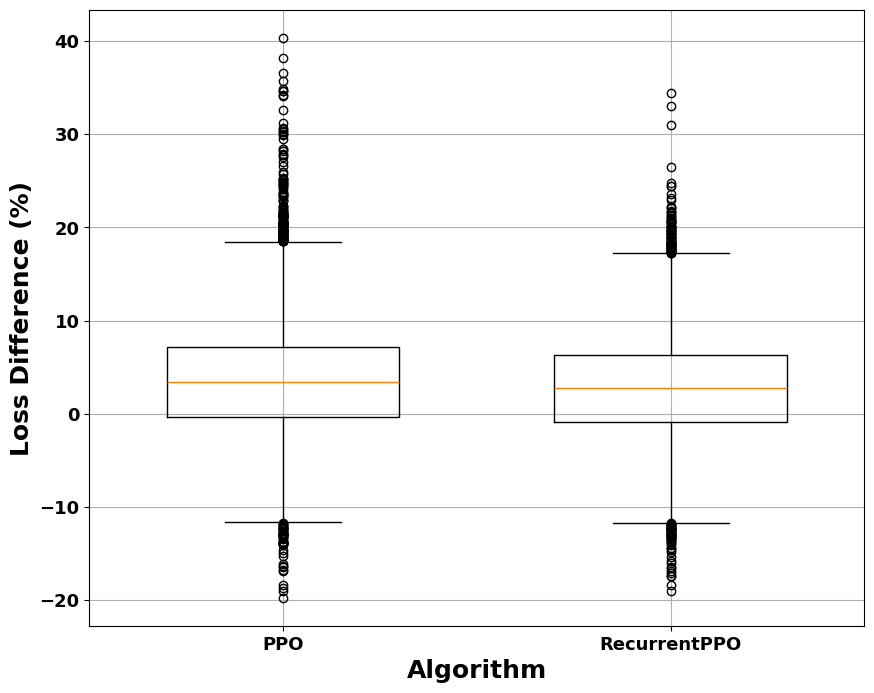

In [13]:
# BOBYQA results
with open('data/BOBYQA_metrics.pickle', 'rb') as f:
    bobyqa_metrics = pickle.load(f)
    
bobyqa_loss = []

for ele in bobyqa_metrics['final_x']:
    loss = -1 * (np.abs(ele[0]) ** 2 + np.abs(ele[1]) ** 2 + (np.abs(ele[0]) - np.abs(ele[1])) ** 2)
    bobyqa_loss.append(loss)
    
del bobyqa_metrics
    
# Tuned PPO results, trained with hidden delays
with open("data/PPO_trained_partially_observable_loss.pickle", 'rb') as f:
    ppo_loss = pickle.load(f)
    
# Tuned Recurrent PPO results, trained with hidden delays
with open("data/RPPO_loss.pickle", 'rb') as f:
    rppo_loss = pickle.load(f)

# Calculate the loss differences
loss_diff_ppo = (np.array(ppo_loss) - np.array(bobyqa_loss)) / np.array(bobyqa_loss) * 100
loss_diff_rppo = (np.array(rppo_loss) - np.array(bobyqa_loss)) / np.array(bobyqa_loss) * 100

fig = plt.figure(figsize=(10, 8))

# Plot the first boxplot
plt.boxplot(loss_diff_ppo, positions=[1], widths=0.6)

# Plot the second boxplot
plt.boxplot(loss_diff_rppo, positions=[2], widths=0.6)

plt.xlabel('Algorithm', fontsize=18)
plt.ylabel('Loss Difference (%)', fontsize=18)
plt.xticks([1, 2], ['PPO', 'RecurrentPPO'], fontsize=13)
plt.yticks(fontsize=13)
plt.grid()

plt.savefig('plots/PPO_RecurrentPPO_performance_comparison.pdf')

RecurrentPPO outperformed PPO. The right tail of the loss-distribution is of special interest, as these are the worst recorded losses. PPO's worst-case loss is 6 percentage points worse than RecurrentPPO's worst-case loss.